In [ ]:
# default_exp prodiag
# default_cls_lvl 3

In [ ]:
#hide
%load_ext line_profiler

# ProDiag Models
> Pytorch Models for Sequential Data

In [ ]:
#export
from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from fastai2.basics import *
from fastai2.callback.progress import *
from fastai2.callback.schedule import *
from fastai2.text.models.qrnn import *

In [ ]:
init_sz = 100
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,clm_shift=[0,-1]),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput,clm_shift=[-1],truncate_sz=init_sz)),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=200+1,stp_sz=100,clm='current')]),
                 splitter=ApplyToDict(ParentSplitter()))
db = seq.databunch(get_hdf_files('test_data/'),shufflish=True,bs=64)

## ProDiag

In [ ]:
#export
class ProDiagTrainer(Callback):
    "`Callback` that regroups lr adjustment to seq_len, AR and TAR."
    def __init__(self, init_size:int=50,alpha=1e6,beta=1):
        self.init_size = init_size
        self.alpha = alpha
        self.beta = beta

#     def begin_batch(self):  
#         self.learn.yb = tuple([y[:,self.init_size:] for y in self.yb])
    
    def after_pred(self):
#         import pdb; pdb.set_trace() 
        p,self.pred_diag,self.est_hidden,self.pred_hidden=self.pred
        self.learn.pred = p
        
    def after_loss(self):
        if not self.training: return
#         import pdb; pdb.set_trace() 
        self.learn.loss += self.beta*self.learn.loss_func(self.pred_diag,*self.yb)
        
        hidden_loss = ((self.est_hidden-self.pred_hidden)/
                       (self.est_hidden.norm()+self.pred_hidden.norm())).pow(2).mean()
        self.learn.loss += self.alpha * hidden_loss

In [ ]:
# class ProgDiag(nn.Module):
#     def __init__(self,input_size,output_size,init_size,hidden_size=100,
#                  rnn='gru',tcn_layer=0,rnn_layer=0,linear_layer = 1):
#         super().__init__()
        
#         def mk_rnn(input_size,hidden_size,num_layers=1):
#             if rnn == 'qrnn': return QRNN(input_size,hidden_size,n_layers=num_layers,window=1)
#             if rnn == 'gru': return nn.GRU(input_size,hidden_size,num_layers=num_layers,batch_first=True)
#             raise ValueError()
        
#         self.out_sz = output_size
#         self.init_size = init_size
#         self.tcn_layer = tcn_layer
#         self.rnn_layer = rnn_layer
        
#         if tcn_layer > 0:
#             self.diag_tcn = TCN(input_size,hidden_size,hl_depth=tcn_layer,hl_width=hidden_size)
#             self.prog_tcn = TCN(input_size-output_size,hidden_size,hl_depth=tcn_layer,hl_width=hidden_size)
        
#             self.diag_state = mk_rnn(hidden_size,hidden_size) 
#             self.prog_state = mk_rnn(hidden_size,hidden_size) 
#         else:
#             self.diag_state = mk_rnn(input_size,hidden_size) 
#             self.prog_state = mk_rnn(input_size-output_size,hidden_size) 
        
#         if rnn_layer > 0:
#             self.post_rnn = mk_rnn(hidden_size,hidden_size,num_layers=rnn_layer) 

#         self.estimator = SeqLinear(hidden_size,output_size,hidden_layer=linear_layer)

#     def forward(self, x,init_state = None):
#         #TCN Layer
#         if self.tcn_layer > 0:
#             x_diag = self.diag_tcn(x)
#             x_prog = self.prog_tcn(x[:,:,:-self.out_sz])[:,self.init_size:]
#         else:
#             x_diag = x
#             x_prog = x[:,self.init_size:,:-self.out_sz]
            
#         #RNN Layer   
#         h_diag,_ = self.diag_state(x_diag) 
#         h_prog_init = h_diag[:,self.init_size-1,:]
#         h_prog,_ = self.prog_state(x_prog,h_prog_init[None,...])
        
#         #Shared RNN Layer
#         if self.rnn_layer > 0:
#             _,h_post_init = self.post_rnn(h_diag[:,:self.init_size-1])
#             est_diag,_ = self.post_rnn(h_diag[:,self.init_size:],h_post_init)

#             est_prog,_ = self.post_rnn(h_prog,h_post_init)
#         else:
#             est_diag = h_diag[:,self.init_size:]
#             est_prog = h_prog
            
#         #Shared Linear Layer
#         est_diag = self.estimator(est_diag)
#         est_prog = self.estimator(est_prog)

# #         out = torch.cat([est_diag,est_prog],dim=2)
# #         import pdb; pdb.set_trace()   
#         return est_prog,est_diag, h_diag[:,self.init_size:,:],h_prog

In [ ]:
#export
class ProgDiag(nn.Module):
    def __init__(self,input_size,output_size,init_size,hidden_size=100,
                 rnn='gru',tcn_layer=0,rnn_layer=1,linear_layer = 1):
        super().__init__()
        
        self.out_sz = output_size
        self.init_size = init_size
        self.tcn_layer = tcn_layer
        
        rnn_kwargs = dict(hidden_size=hidden_size,num_layers=rnn_layer,rnn=rnn,ret_full_hidden=True)
        
        if tcn_layer > 0:
            self.diag_tcn = TCN(input_size,hidden_size,hl_depth=tcn_layer,hl_width=hidden_size)
            self.prog_tcn = TCN(input_size-output_size,hidden_size,hl_depth=tcn_layer,hl_width=hidden_size)
        
            self.diag_state = RNN(hidden_size,**rnn_kwargs) 
            self.prog_state = RNN(hidden_size,**rnn_kwargs) 
        else:
            self.diag_state = RNN(input_size,**rnn_kwargs) 
            self.prog_state = RNN(input_size-output_size,**rnn_kwargs) 

        self.estimator = SeqLinear(hidden_size,output_size,hidden_layer=linear_layer)

    def forward(self, x,init_state = None):
        #TCN Layer
        if self.tcn_layer > 0:
            x_diag = self.diag_tcn(x)
            x_prog = self.prog_tcn(x[:,:,:-self.out_sz])[:,self.init_size:]
        else:
            x_diag = x
            x_prog = x[:,self.init_size:,:-self.out_sz]
            
        #RNN Layer   
        out_diag,h_diag = self.diag_state(x_diag) 
        h_prog_init = h_diag[:,:,self.init_size-1,:]
#         import pdb; pdb.set_trace()
        out_prog,h_prog = self.prog_state(x_prog,h_prog_init)
            
        #Shared Linear Layer
        est_diag = self.estimator(out_diag[:,self.init_size:])
        est_prog = self.estimator(out_prog)

#         out = torch.cat([est_diag,est_prog],dim=2)
#         import pdb; pdb.set_trace()   
        return est_prog,est_diag, h_diag[:,:,self.init_size:,:],h_prog

In [ ]:
model = ProgDiag(2,1,init_sz,rnn='gru',linear_layer=2,rnn_layer=3,hidden_size=42)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=ProDiagTrainer(init_sz,alpha=1e7),opt_func=ranger)

In [ ]:
# apply_init(model.diag_tcn)
# apply_init(model.prog_tcn)
# apply_init(model.diag_state,nn.init.orthogonal_)
# apply_init(model.prog_state,nn.init.orthogonal_)
# apply_init(model.estimator)

In [ ]:
lrn.lr_find()

KeyboardInterrupt: 

In [ ]:
lrn.fit_one_cycle(20,lr_max=3e-3,pct_start=0.05)

epoch,train_loss,valid_loss,time
0,15.647421,0.169237,00:09
1,2.741256,0.035993,00:10
2,0.558884,0.006978,00:10
3,0.129843,0.003664,00:09
4,0.042067,0.016252,00:09
5,0.022583,0.001736,00:09
6,0.019954,0.005753,00:09
7,0.013484,0.008131,00:09
8,0.009989,0.001178,00:09
9,0.007703,0.002172,00:09


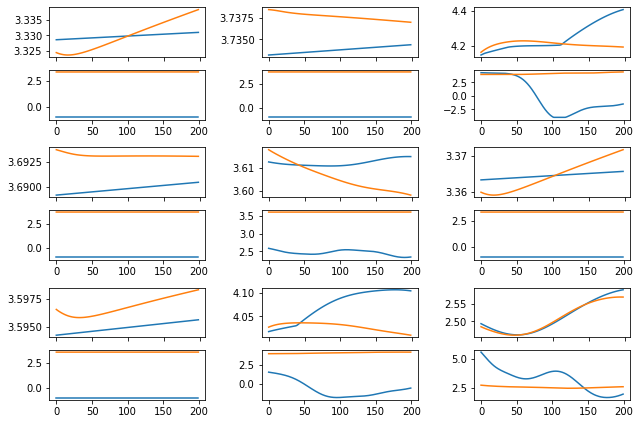

In [ ]:
lrn.show_results(ds_idx=0,max_n=9)

IndexError: index 1 is out of bounds for dimension 2 with size 1

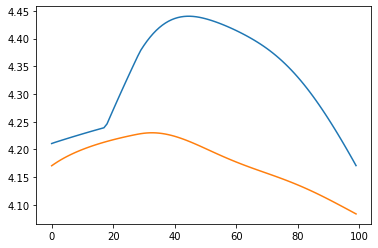

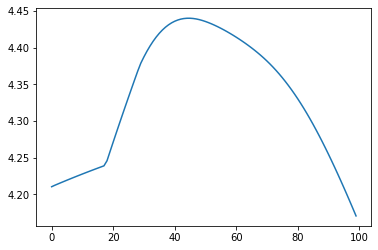

In [ ]:
btch = 6
plt.figure()
plt.plot(lrn.y.cpu()[btch,:,0])
plt.plot(lrn.pred.cpu()[btch,:,0])
plt.figure()
plt.plot(lrn.y.cpu()[btch,:,0])
plt.plot(lrn.pred.cpu()[btch,:,1])

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_model.ipynb.
Converted 02_learner.ipynb.
Converted 10_performance_test.ipynb.
Converted 11_ProDiag.ipynb.
Converted 90_imu_example.ipynb.
Converted 93_mdt_benchmark.ipynb.
Converted 96_EEG.ipynb.
Converted 97_Battery.ipynb.
Converted index.ipynb.
